In [1]:
category = 'gluten_free_flour'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from product_meta_analysis.database.database import Database
from product_meta_analysis.aggregate import reddit as r
from product_meta_analysis.analyze import basic_plots as p



### Get data

In [3]:
# TODO: add a read_pandas function to Database class
db = Database()
comments = db.read(f"""
    select 
        c.comment_id,
        c.upvotes,
        c.parent_id, 
        a.sentence_ix, 
        a.brand,
        a.annotation_id
    from reddit_comments c 
    inner join reddit_comment_annotations a
        on a.comment_id = c.comment_id
    where c.category='{category}'
    """)
comments = pd.DataFrame(comments, columns=['comment_id', 'upvotes', 'parent_id', 'sentence_ix', 'brand', 'annotation_id'])
db.close() 


elligible_comments = r.get_eligible_top_level_comments(comments)
    
elligible_comments.head(5)

,comment_id,upvotes,parent_id,sentence_ix,brand,annotation_id,brand_count,parent_name,parent_type
0,dx89ctf,8,t3_8bnn0y,0,Bob's Red Mill,dx89ctf02,1,8bnn0y,t3
1,dx8ku69,7,t3_8bnn0y,0,Cup4cup,dx8ku6901,1,8bnn0y,t3
2,dx8a8g5,5,t3_8bnn0y,0,King Arthur,dx8a8g500,2,8bnn0y,t3
3,dx8a8g5,5,t3_8bnn0y,1,Bob's Red Mill,dx8a8g512,2,8bnn0y,t3
4,dx8ex8y,5,t3_8bnn0y,3,King Arthur,dx8ex8y30,1,8bnn0y,t3


### Summary across brands

In [4]:
summary = r.get_summary_stats(elligible_comments)
summary

{'posts': 9, 'comments': 40, 'upvotes': 140, 'brands': 3}

### Summary by brand

In [5]:
brand_summary = r.get_brand_summary(elligible_comments)
brand_summary

,Brand,Total Votes,Total Comments,Average Votes per Comment
0,Bob's Red Mill,77,23,3.3
1,King Arthur,46,12,3.8
2,Cup4cup,43,11,3.9


### Plots

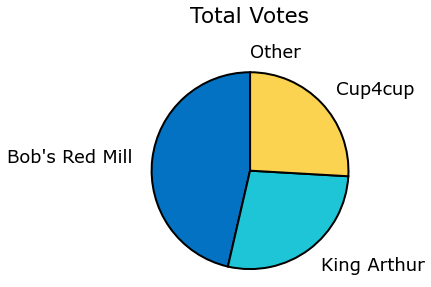

In [6]:
p.create_pie_chart(brand_summary)

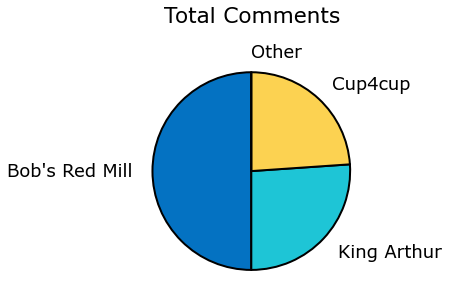

In [7]:
p.create_pie_chart(brand_summary, column='Total Comments')

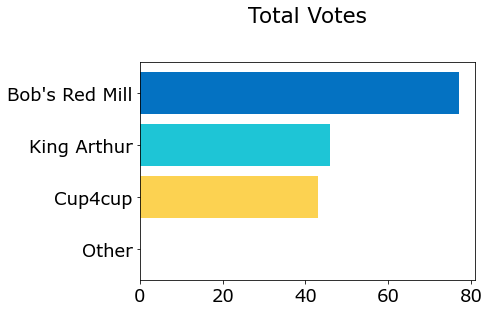

In [8]:
p.create_bar_chart(brand_summary)